# Audio analysis in a Jupyter notebook

## Danger! Don't try this at home.
A powerful audio amplifier can put out sound pressure levels that can damage your hearing, and signal levels that could be dangerous or damage your equipment. I have extensive experience in electronic measurement, but I'm warning you that small mistakes can lead to big damage. Some amplifiers can have AC and DC levels on their output terminals, that are not what you might expect.

Don't attempt this experiment unless you're qualified to perform elecronic testing, as a technician or engineer. Make sure you understand and agree with the methods that I've described, before following them.

### Aside: Data collection in Jupyter?

I use Jupyter as my "electronic lab notebook." Of course this led me to wonder if I could actually have Jupyter perform my data collection. I could have a code cell collect my data, and then analyze the data in the same notebook.

### *In general, this turns out to be a bad idea*. 

Think about the ways in which this can go wrong. If you collect data into a variable in Jupyter, when you end your Python session, it's gone. You can run Jupyter cells in any sequence, thus accidentally over-writing valuable data and not knowing which variables are associated with which measurement conditions.

But because Jupyter is so easy and fun, it's really tempting. For this reason, I sometimes take the risk anyway, for instance:

* When I'm just setting up an experiment, building my code, and testing the individual measurement functions to make sure they work. In this case I'm not really collecting archival data. But I'm combining code, tests, and graphs, in a single document speeds up exploration.

* When it's a hobby project, and I can afford to screw up. The nice thing about Jupyter is that I can write my report as I'm going along, and I have something that I can share when I'm done.

* When it's for keeps, I typically move my Python code into a stand alone program that stores data in files, then I use Jupyter to analyze the data in those files.

### There are ways to manage the problem

But you have to think about it. One way is to collect data into files, and then load and display the data from those files. I name my files after the system time stamp, so it's impossible to over-write good data by accident. You can print a string representation of a variable, such as str(y), and use eval() to read it back in. You can print dictionary structures that contain meta-data, helping to identify what's in each file. Using your smarts to manage your lab data is part of doing science by computer.

### Back to the task at hand

In this notebook, I'm going to use the PC audio hardware to perform a frequency response on an audio amplifier. My setup is going to be pretty simple:

PC audio output $\rightarrow$ Amplifier $\rightarrow$ Transformer $\rightarrow$ PC audio input

In addition, I can connect and disconnect a speaker from the amplifier. More details:

* PC audio = Cheap USB audio adapter from Amazon

* Amplifier = Gallien-Krueger "Backline 600" bass amplifier head

* Transformer = Radial JDI passive direct box

* Speaker = Various homemade bass speaker

For non-musicians, a "passive direct box" is an audio transformer coupling box with varying amounts of bells and whistles. I'm using it to isolate the amplifier, and attenuate the signal to avoid frapping the audio hardware on my PC.

## Create the tone cluster waveform
A tone cluster waveform is a set of discrete frequencies, summed together. My waveform is constructed so that each frequency completes an integer number of cycles within the block length of the FFT measurement. This eliminates the need for apodization (windowing) in the FFT, and produces a stable display, albeit at discrete frequencies. Since I don't expect anything interesting to happen in between those frequencies, this is a practical way for doing my measurements.

In [10]:
import pyaudio
import numpy as np

# Compute tone cluster waveform

block_length = 8192 # Samples per FFT block, needs to be power of 2
sample_rate = 44100 # Audio sampling rate in Hz

fmin = 10 # Minimum frequency we're interested in
fmax = 20000 # Maximum frequency we're interested in
ratio = 1.1 # Approximate ratio from one frequency to the next

# Frequency and time scales for audio analysis

f_array = np.fft.rfftfreq(block_length, d = 1/sample_rate)
t_array = np.linspace(0, block_length/sample_rate, block_length)

# Compute tone cluster waveform

j = int(np.ceil(fmin*block_length/sample_rate)) # Initial cycles per block
fpos = [] # List of frequencies in cycles per block
a = np.zeros_like(t_array, dtype = np.float)

while True:
    fpos.append(j)
    f = j*sample_rate/block_length # Get this frequency

    omega = 2*np.pi*f
    phase = np.random.rand()*2*np.pi
    a = a + np.sin(omega*t_array + phase)
    
    fnext = f*ratio # Estimate the next frequency
    j = int(np.ceil(fnext*block_length/sample_rate)); # Convert to next higher integer
    if fnext > fmax:
        break

# Normalize to +/- 30000, convert to integer format

a = a*30000/max(abs(a))
block = np.array(a, dtype = np.int16)
block0 = np.zeros_like(block) # for when tone is turned off

## Start audio data collection

Now this is really playing fast and loose. I'm going to start a thread running, which will keep going as long as the iPython kernel isn't restarted. A global variable turns the tone generator on and off...

In [60]:
btonez = False # set to True to turn tone generator on
newdata = False # for sychronization

def callback(in_data, frame_count, time_info, status):
    global yaudio, btonez, newdata

    # See if we're getting data faster than we can handle it
    
    if frame_count > block_length:
        print('overrun', frame_count)

    # Store as global, for use by main program
    
    yaudio = np.fromstring(in_data, np.int16)
    newdata = True

    # Audio is either on or off, depending on GUI selection
    
    if btonez:
        return (block, pyaudio.paContinue)
    else:
        return (block0, pyaudio.paContinue)

# Set up the audio data stream, basic settings supported by most PC's

p = pyaudio.PyAudio()

stream = p.open(format = pyaudio.paInt16,
                channels = 1,
                rate = sample_rate,
                output = True,
                input = True,
                frames_per_buffer = block_length,
                stream_callback = callback,
                start = False)

stream.start_stream()

## Start the signal generator
### Danger: This is going to be loud.
Also, system alerts such as beeps and boops will come through your speakers, so don't trust the volume settings on your amplifier to protect your ears and equipment.

Setting btonez to False will turn the signal generator back off.

In [69]:
btonez = True

In [59]:
stream.stop_stream()
stream.close()

## Collect and display an audio graph
This is my basic audio measurement. It assumes that the tone cluster waveform is running. I don't care about the full FFT, but only the data points where the waveform has a sinewave component.

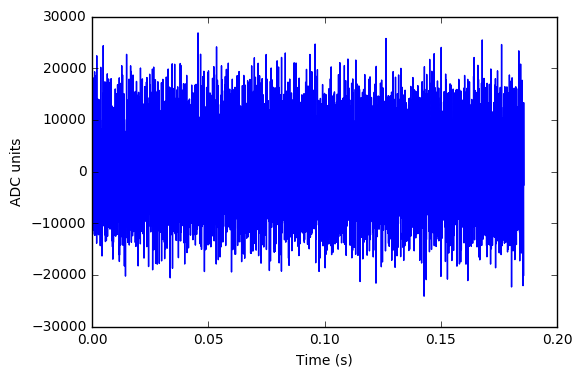

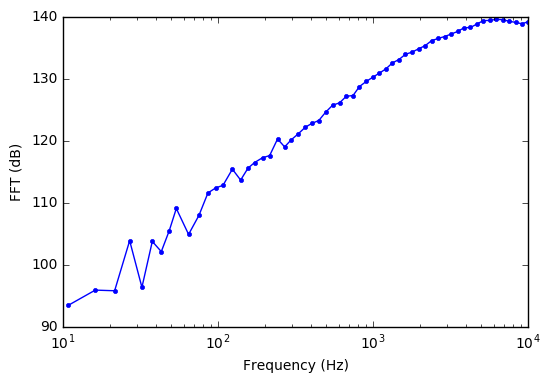

In [99]:
def go_collect(verbose = False):
    global newdata
    # wait until a new data frame has arrived
    while not newdata:
        pass
    data = yaudio
    # mark the data as old
    newdata = False
    
    # turn into spectrum
    
    data = data - np.mean(data) # remove DC offset
    dfft = abs(np.fft.rfft(data))
    
    f = array([f_array[i] for i in fpos])
    y = 20*np.log10(np.array([dfft[i] for i in fpos]))
    
    if verbose:
        plot(t_array, data)
        xlabel('Time (s)')
        ylabel('ADC units')
        show()

        semilogx(f, y, marker = '.')
        gca().set_xlim(10, 10000)
        xlabel('Frequency (Hz)')
        ylabel('FFT (dB)')
        show()
    
    return f, y
    
dummy = go_collect(verbose = True)

In [74]:
# data collection with averaging

def collect_average(npts = 10):
    ya = array([go_collect() for i in range(npts)])
    f = ya[0][0]
    y = average([yaa[1] for yaa in ya], axis = 0)
    return f, y

## Now for an experiment
Unhook the speaker. Make one measurement

In [81]:
f0, y0 = collect_average(npts = 100)

Reconnect the speaker. Make another measurement

In [82]:
f1, y1 = collect_average(npts = 100)

The difference is the effect of the speaker on the amplifier output signal, in dB.

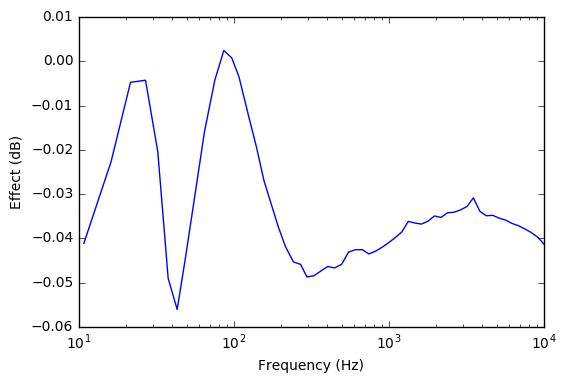

In [113]:
ydiff = y1 - y0
semilogx(f1, ydiff)
gca().set_xlim(10, 10000)
xlabel('Frequency (Hz)')
ylabel("Effect (dB)")
show()

Some interesting things to note: First, there's some interesting activity at low frequencies. This is due to the varying impedance of the speaker, which is ported, with a roughly 40 Hz port. Next, the overall loss is roughly 0.04 dB at higher frequencies. The insertion gain should be:

$g = \dfrac {R_L} {R_L + R_0}$

where $R_L$ is the load impedance and $R_0$ is the output impedance of the amplifier. The damping factor is defined by:

$DF = \dfrac {R_L} {R_0}$

Solving for DF...

$DF = \dfrac g {1-g}$

In [123]:
gdb = -0.05
g = 10**(gdb/20)
df = g/(1 - g)
print('damping factor', df)
print('output impedance (Ohms)', 8/df)

damping factor 173.2182724662642
output impedance (Ohms) 0.04618450401390575


## Conclusions

Most importantly, we've figured out how to perform audio measurements within a Jupyter notebook, and have measured the effect of driving a speaker, on the out signal of a bass amplifier. We've assigned a damping factor of roughly 170 to a popular (for its time) bass amplifier.

In [121]:
# Saving the data in case we want to use it later:
open('y0.dat', 'w').write(str({'comment': 'Speaker disconnected',
                           'f': f1,
                           'y': y0}))
open('y1.dat', 'w').write(str({'comment': 'Speaker connected',
                           'f': f1,
                           'y': y1}))

2497